In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print("-"*50)
print('Transfer learning- Cats & Dogs')
print("-"*50)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  print(f"Gpu Enabled: {gpu_devices[0].name}")
else:
  print("No gpu")

--------------------------------------------------
Transfer learning- Cats & Dogs
--------------------------------------------------
Gpu Enabled: /physical_device:GPU:0


In [2]:
#to mount google drive

print("="*50)
print("Mounting google drive")
print("="*50)

from google.colab import drive
drive.mount('/content/drive')

print(f"Google drive mounted")

Mounting google drive
Mounted at /content/drive
Google drive mounted


In [3]:
#Set up dataset path

print("-"*50)
print("Setting up dataset path")
print("-"*50)

!mkdir -p /content/raw_train
!unzip -q /content/drive/MyDrive/train.zip -d /content/raw_train




--------------------------------------------------
Setting up dataset path
--------------------------------------------------


In [4]:
!find /content/raw_train/train -type f | wc -l

25000


In [5]:
#Importing images n fixing dir

print("="*50)
print("Spliting images n making required dir")
print("="*50)

import shutil
import random

source_dir = '/content/raw_train/train'
base_dir = '/content/data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for split in [train_dir, val_dir]:
  os.makedirs(os.path.join(split, 'cats'), exist_ok = True)
  os.makedirs(os.path.join(split, 'dogs'), exist_ok=True)

images = os.listdir(source_dir)

random.shuffle(images)

split_index = int(0.8*len(images))

train_images = images[:split_index]
val_images = images[split_index:]


def move_images(image_list, target_dir):
  for img in image_list:

    if img.startswith('cat'):
      label = 'cats'
    elif img.startswith('dog'):
      label = 'dogs'
    else:
      continue

    shutil.copy(
        os.path.join(source_dir, img),
        os.path.join(target_dir, label, img)
    )

move_images(train_images, train_dir)
move_images(val_images, val_dir)


Spliting images n making required dir


In [6]:
#verifying if the path exists

if os.path.exists(train_dir):
  print("Training directory found")
  train_cats = len(os.listdir(os.path.join(train_dir, 'cats')))
  train_dogs = len(os.listdir(os.path.join(train_dir, 'dogs')))
  print(f"Cats: {train_cats}")
  print(f"dogs: {train_dogs}")

else:
  print("Not found")

if os.path.exists(val_dir):
  print("Training directory found")
  val_cats = len(os.listdir(os.path.join(val_dir, 'cats')))
  val_dogs = len(os.listdir(os.path.join(val_dir, 'dogs')))
  print(f"Cats: {val_cats}")
  print(f"dogs: {val_dogs}")

else:
  print("Not found")

Training directory found
Cats: 10019
dogs: 9981
Training directory found
Cats: 2481
dogs: 2519


Visualize the data


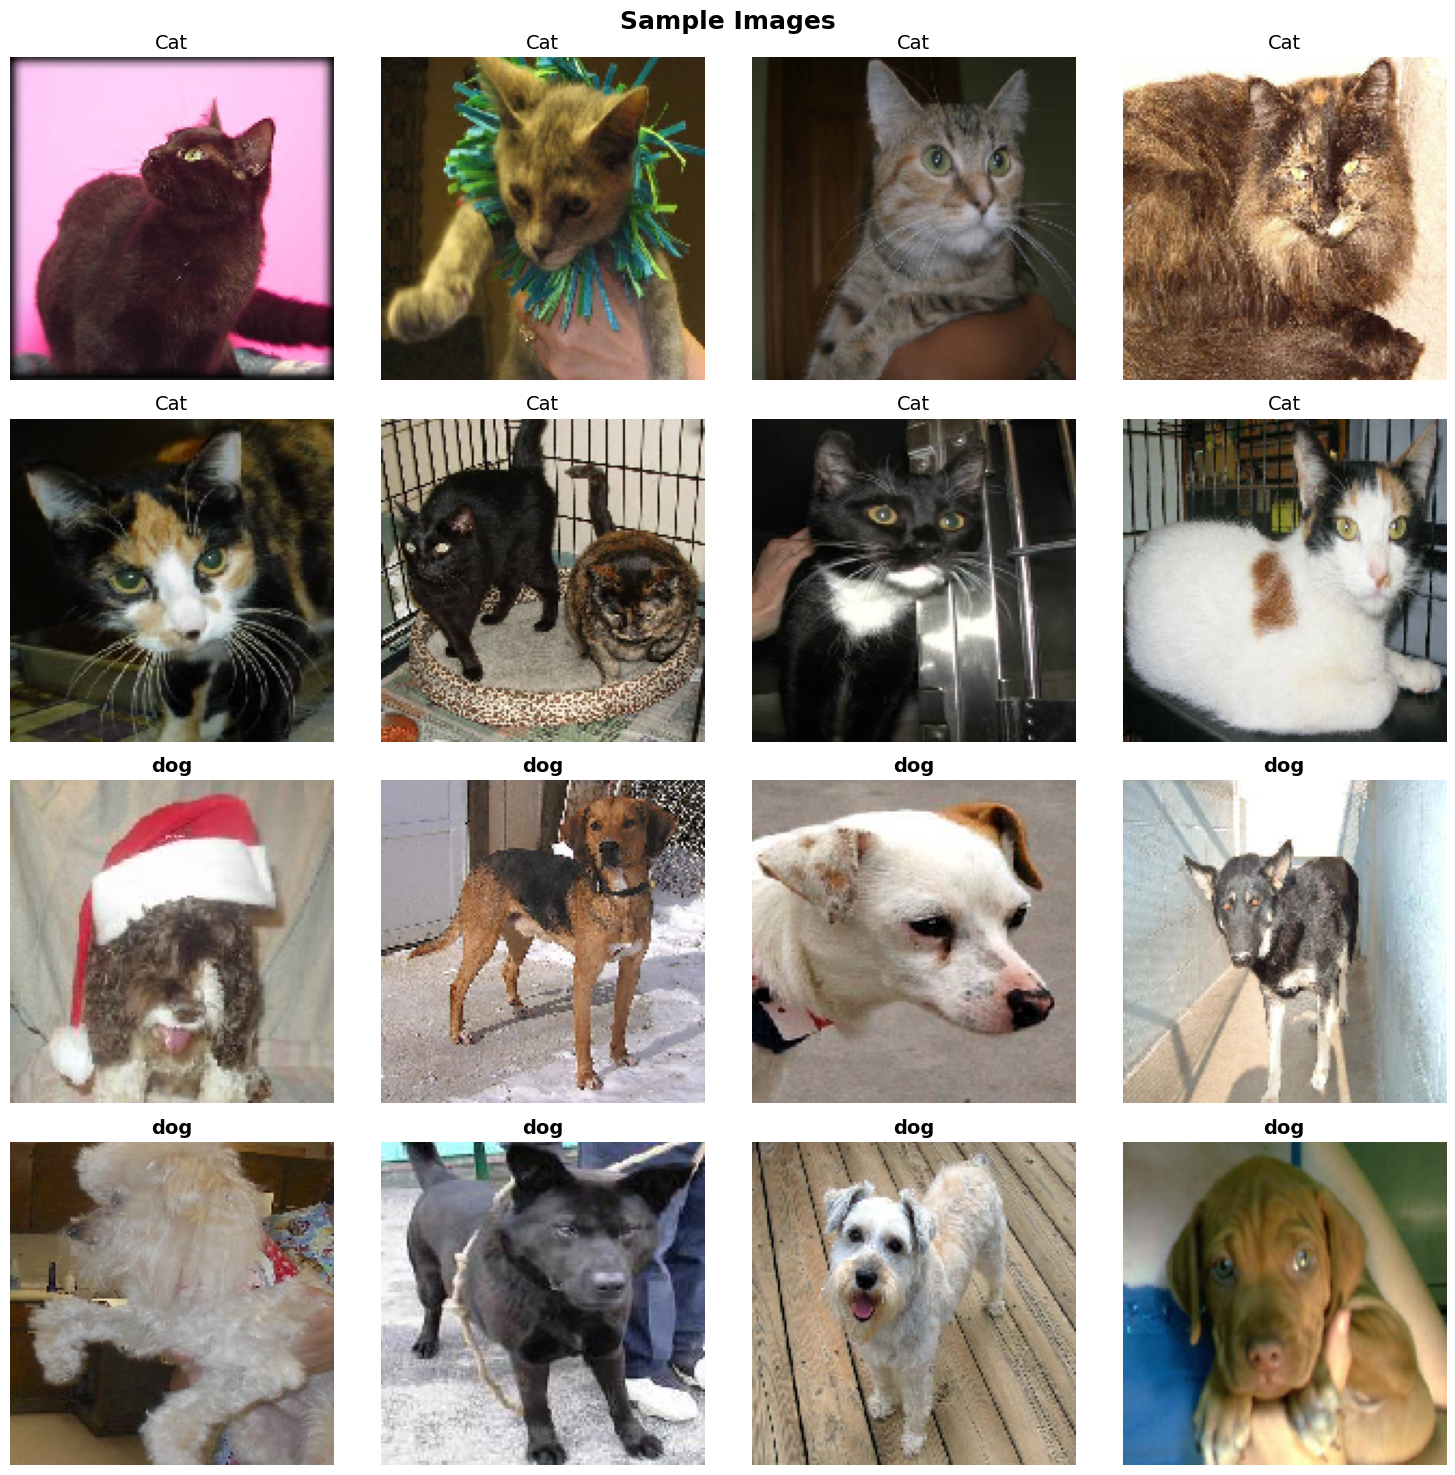

In [7]:
#visualize the data

print("="*50)
print("Visualize the data")
print("="*50)

from tensorflow.keras.preprocessing import image

cat_dir = os.path.join(train_dir, 'cats')
dog_dir = os.path.join(train_dir, 'dogs')

sample_cat_files = os.listdir(cat_dir)[8:]
sample_dog_files = os.listdir(dog_dir)[8:]

fig, axes = plt.subplots(4, 4, figsize = (15,15))

for i in range(8):
  img_path = os.path.join(cat_dir, sample_cat_files[i])
  img = image.load_img(img_path, target_size= (150,150))
  img_array = image.img_to_array(img)/255.0

  row = i//4
  col = i%4
  axes[row, col].imshow(img_array)
  axes[row, col].set_title("Cat", fontsize=14)
  axes[row,col].axis('off')

for i in range(8):
  img_path = os.path.join(dog_dir, sample_dog_files[i])
  img = image.load_img(img_path, target_size= (150,150))
  img_array = image.img_to_array(img)/255.0

  row = (i//4)+2
  col = i%4
  axes[row, col].imshow(img_array)
  axes[row, col].set_title("dog", fontsize=14, fontweight = 'bold')
  axes[row,col].axis('off')

plt.suptitle("Sample Images", fontsize = 18, fontweight = 'bold')
plt.tight_layout()
plt.show()


In [8]:
#Data preprocessing

from tensorflow.keras.applications.resnet50 import preprocess_input

print("="*50)
print("Data preprocessing")
print("="*50)

img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary'
)


print(f"Image size: {img_size}*{img_size} (ResNet50 std)")
print(f"Batch size: {batch_size}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print("-"*70)

Data preprocessing
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Image size: 224*224 (ResNet50 std)
Batch size: 32
Training samples: 20000
Validation samples: 5000
----------------------------------------------------------------------


In [9]:
#load pre trained ResNet50

print("="*50)
print("Loading pre trained ResNet50")
print("="*50)

base_model = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Total Layers in RestNet50: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable} (frozen for now)")
print("\nWhat is RestNet50")
print("50 layers deep neural network")
print("Trained on ImageNet (14M images, 1000 classes)")
print("Took weeks to train on massive GPUs")
print("Already knows: edges, textures, shapes, objects")
print("We just teach it: cat vs dog!")
print("="*50)


Loading pre trained ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Total Layers in RestNet50: 175
Trainable: True (frozen for now)

What is RestNet50
50 layers deep neural network
Trained on ImageNet (14M images, 1000 classes)
Took weeks to train on massive GPUs
Already knows: edges, textures, shapes, objects
We just teach it: cat vs dog!


In [10]:
#build the transfer model

print("Build the model")

model = keras.Sequential([
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid')
])

print("="*50)
print("Model Architecture")
print("="*50)

model.summary


print("="*50)
print("How Transfer Learning works: ")
print("="*50)
print("1. ResNet50 Base (FROZEN - already trained):")
print("Extracts features from images")
print("Knows edges, textures, shapes, patterns")
print("23M+ parameters already optimized!")
print("\n2. Our Custom Layers (TRAINABLE):")
print("GlobalAveragePooling: Summarize features")
print("Dense(256): Learn cat vs dog patterns")
print("Dense(1): Final decision - cat or dog?")
print("Only ~260K parameters to train!")
print("\nIt's like having a PhD in vision, just learning cat vs dog!")

trainable_para = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_para = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"Trainable parameters: {trainable_para :,}")
print(f"Non Trainable parameters: {non_trainable_para :,}")
print(f"Total parameters: {trainable_para +non_trainable_para :,}")


Build the model
Model Architecture
How Transfer Learning works: 
1. ResNet50 Base (FROZEN - already trained):
Extracts features from images
Knows edges, textures, shapes, patterns
23M+ parameters already optimized!

2. Our Custom Layers (TRAINABLE):
GlobalAveragePooling: Summarize features
Dense(256): Learn cat vs dog patterns
Dense(1): Final decision - cat or dog?
Only ~260K parameters to train!

It's like having a PhD in vision, just learning cat vs dog!
Trainable parameters: 14,979,585
Non Trainable parameters: 9,142,144
Total parameters: 24,121,729


In [11]:
#model compilation

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-5),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print("=" * 50)
print("Model Compiled!")
print("=" * 50)
print("Optimizer: Adam (lr=0.001)")
print("Loss: Binary Crossentropy")
print("Metric: Accuracy")

Model Compiled!
Optimizer: Adam (lr=0.001)
Loss: Binary Crossentropy
Metric: Accuracy


In [12]:
#training

print("="*50)
print("Transfer learning training")
print("="*50)

epochs = 10

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    restore_best_weights = True,
    verbose = 1,
)

checkpoint = ModelCheckpoint(
    '/content/best_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = val_generator,
    callbacks =[early_stop, checkpoint],
    verbose = 1
)

Transfer learning training


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8227 - loss: 0.3688
Epoch 1: val_accuracy improved from -inf to 0.98240, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 312s 460ms/step - accuracy: 0.8229 - loss: 0.3685 - val_accuracy: 0.9824 - val_loss: 0.0460
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9675 - loss: 0.0846
Epoch 2: val_accuracy improved from 0.98240 to 0.98720, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 289s 462ms/step - accuracy: 0.9675 - loss: 0.0846 - val_accuracy: 0.9872 - val_loss: 0.0379
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9761 - loss: 0.0622
Epoch 3: val_accuracy did not improve from 0.98720
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 452ms/step - accuracy: 0.9761 - loss: 0.0622 - val_accuracy: 0.9870 - val_loss: 0.0392
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9798 - loss: 0.0555
Epoch 4: val_accuracy improved from 0.98720 to 0.98740, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 291s 465ms/step - accuracy: 0.9798 - loss: 0.0555 - val_accuracy: 0.9874 - val_loss: 0.0413
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9854 - loss: 0.0386
Epoch 5: val_accuracy improved from 0.98740 to 0.98800, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 291s 466ms/step - accuracy: 0.9854 - loss: 0.0386 - val_accuracy: 0.9880 - val_loss: 0.0387
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9870 - loss: 0.0337
Epoch 6: val_accuracy improved from 0.98800 to 0.98880, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 450ms/step - accuracy: 0.9870 - loss: 0.0337 - val_accuracy: 0.9888 - val_loss: 0.0411
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9858 - loss: 0.0360
Epoch 7: val_accuracy did not improve from 0.98880
625/625 ━━━━━━━━━━━━━━━━━━━━ 280s 448ms/step - accuracy: 0.9858 - loss: 0.0360 - val_accuracy: 0.9888 - val_loss: 0.0385
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9896 - loss: 0.0280
Epoch 8: val_accuracy improved from 0.98880 to 0.98920, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 282s 452ms/step - accuracy: 0.9896 - loss: 0.0280 - val_accuracy: 0.9892 - val_loss: 0.0424
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9912 - loss: 0.0246
Epoch 9: val_accuracy did not improve from 0.98920
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 453ms/step - accuracy: 0.9912 - loss: 0.0246 - val_accuracy: 0.9884 - val_loss: 0.0424
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9927 - loss: 0.0208
Epoch 10: val_accuracy improved from 0.98920 to 0.98980, saving model to /content/best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 455ms/step - accuracy: 0.9927 - loss: 0.0208 - val_accuracy: 0.9898 - val_loss: 0.0396
Restoring model weights from the end of the best epoch: 10.


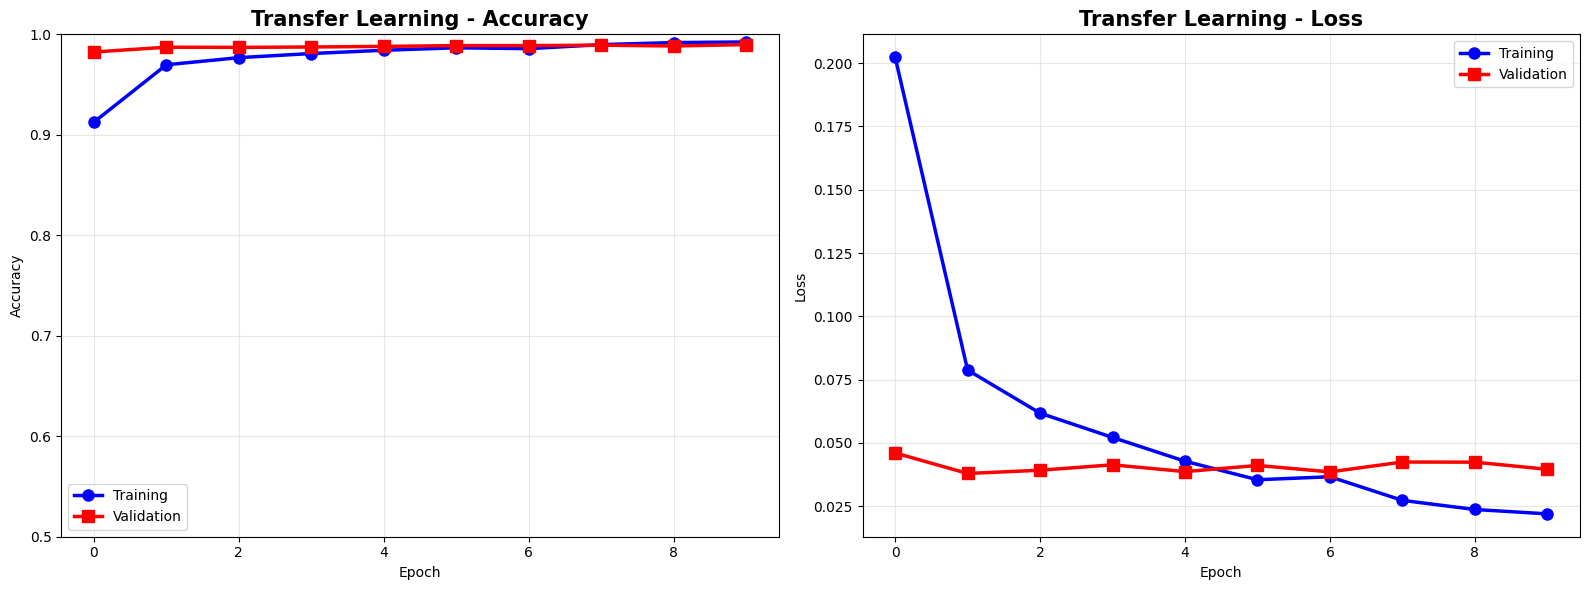

Final results:
Training Accuracy: 99.24%
Validation Accuracy: 98.98%


In [13]:
#visualization

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_completed = len(acc)
epochs_range = range(epochs_completed)

fig, axes = plt.subplots(1, 2, figsize = (16, 6))
axes[0].plot(epochs_range, acc, 'bo-', label='Training', linewidth=2.5, markersize=8)
axes[0].plot(epochs_range, val_acc, 'rs-', label='Validation', linewidth=2.5, markersize=8)
axes[0].set_title('Transfer Learning - Accuracy', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Loss
axes[1].plot(epochs_range, loss, 'bo-', label='Training', linewidth=2.5, markersize=8)
axes[1].plot(epochs_range, val_loss, 'rs-', label='Validation', linewidth=2.5, markersize=8)
axes[1].set_title('Transfer Learning - Loss', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_train_acc = acc[-1] * 100
final_val_acc = val_acc[-1] * 100


print("="*50)
print("Final results:")
print("="*50)
print(f"Training Accuracy: {final_train_acc:.2f}%")
print(f"Validation Accuracy: {final_val_acc:.2f}%")
print("="*50)


Making predictions...


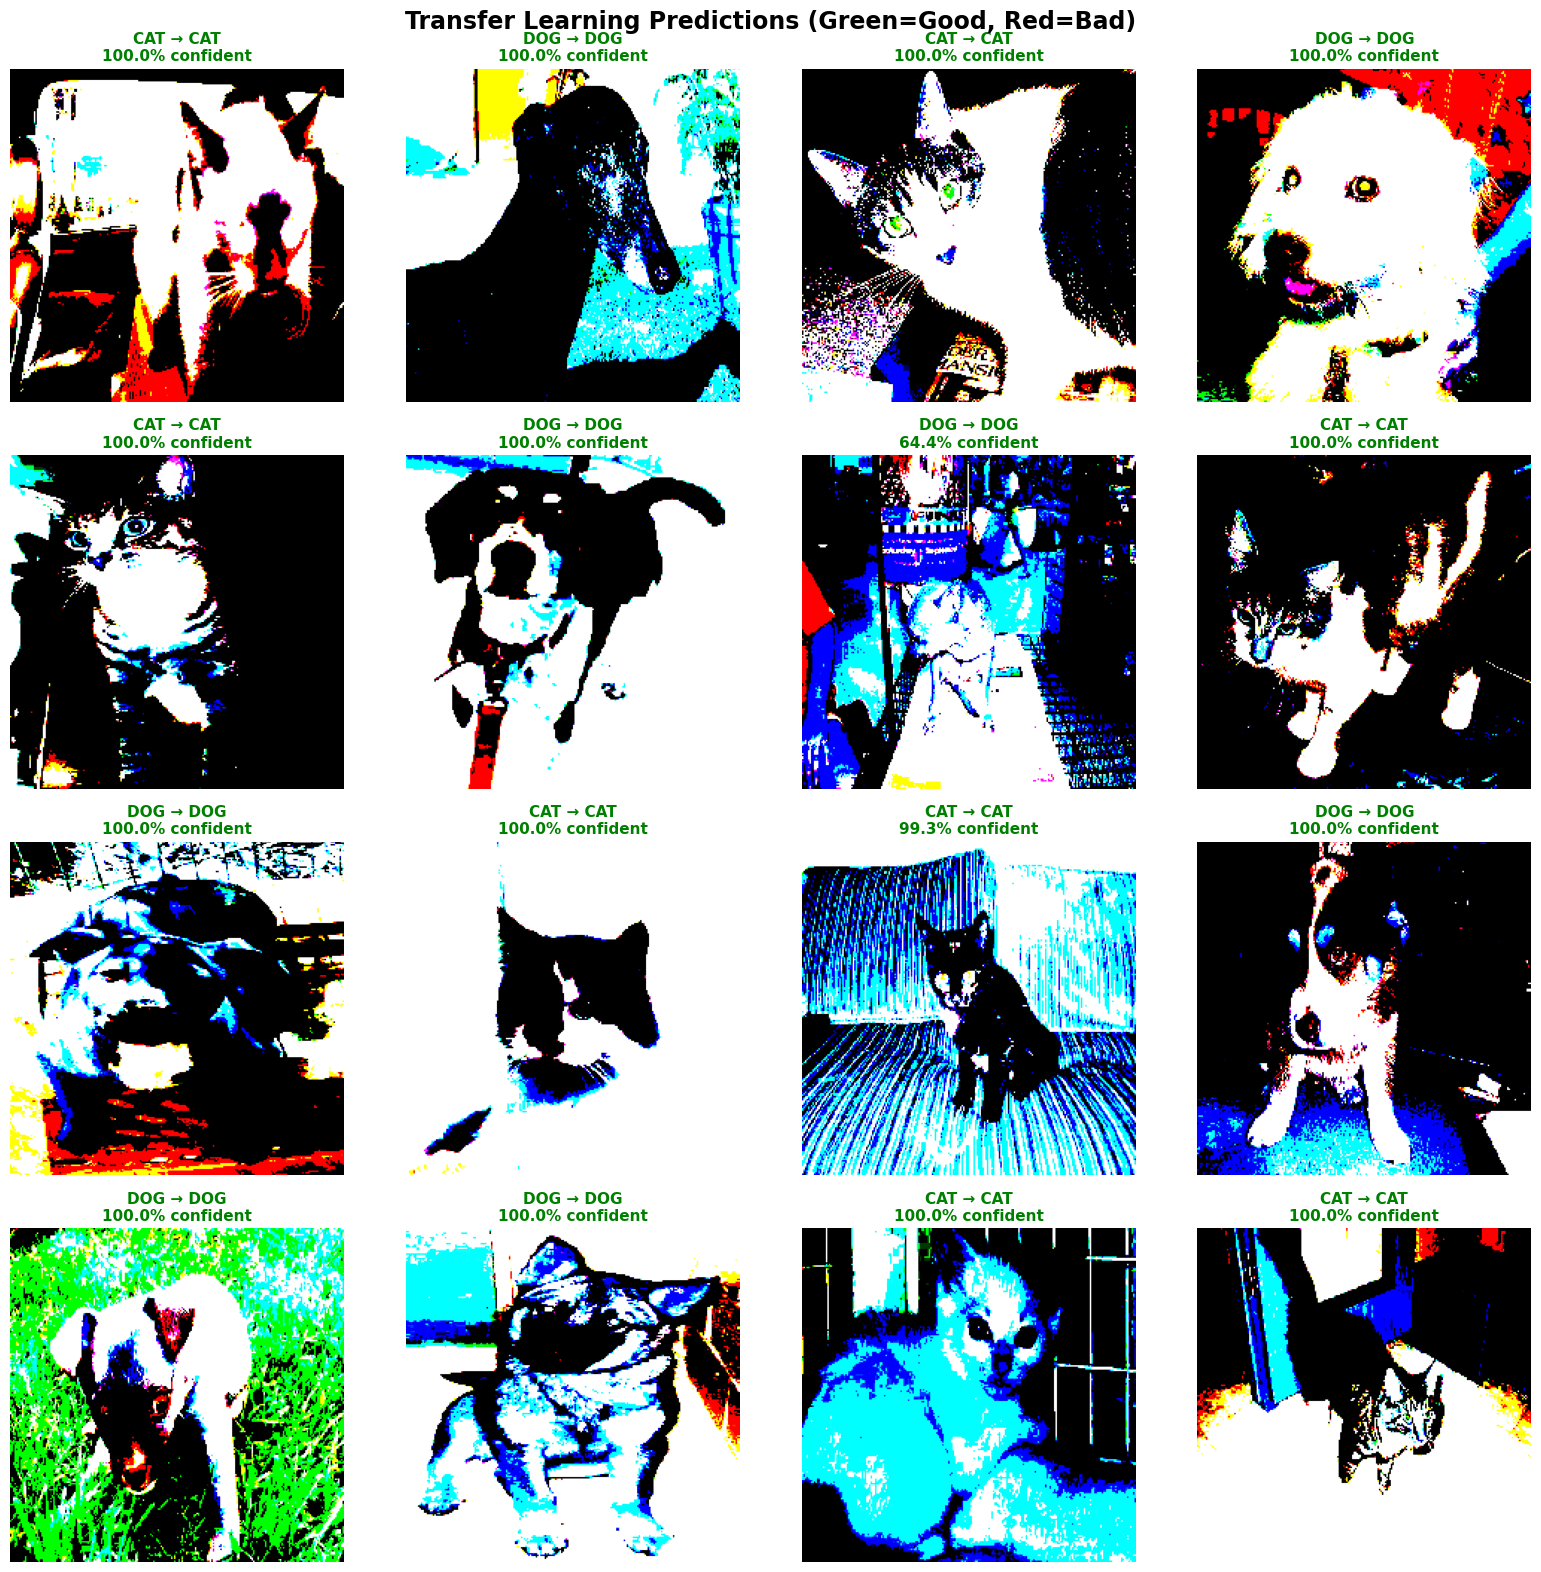


 31/32 correct (96.9%)


In [19]:
#predictions

print("="*50)
print("Making predictions...")
print("="*50)

val_images, val_labels = next(val_generator)
predictions = model.predict(val_images, verbose = 0)

fig, axes = plt.subplots(4, 4, figsize =(16,16))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(val_images[i])

    pred_prob = predictions[i][0]
    pred_class = "DOG" if pred_prob > 0.5 else "CAT"
    true_class = "DOG" if val_labels[i] == 1 else "CAT"
    confidence = pred_prob * 100 if pred_prob > 0.5 else (1 - pred_prob) * 100

    color = 'green' if pred_class == true_class else 'red'

    axes[i].set_title(
        f"{true_class} → {pred_class}\n{confidence:.1f}% confident",
        fontsize=11,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle("Transfer Learning Predictions (Green=Good, Red=Bad)",
             fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

correct = np.sum((predictions>0.5).astype(int).flatten() == val_labels)
print(f"\n {correct}/32 correct ({correct/32*100:.1f}%)")

Confusion Matrix
Making predictions on all validation images....
Processed 160 images....
Processed 320 images....
Processed 480 images....
Processed 640 images....
Processed 800 images....
Processed 960 images....
Processed 1120 images....
Processed 1280 images....
Processed 1440 images....
Processed 1600 images....
Processed 1760 images....
Processed 1920 images....
Processed 2080 images....
Processed 2240 images....
Processed 2400 images....
Processed 2560 images....
Processed 2720 images....
Processed 2880 images....
Processed 3040 images....
Processed 3200 images....
Processed 3360 images....
Processed 3520 images....
Processed 3680 images....
Processed 3840 images....
Processed 4000 images....
Processed 4160 images....
Processed 4320 images....
Processed 4480 images....
Processed 4640 images....
Processed 4800 images....
Processed 4960 images....

Analyzed 4992 validation images!


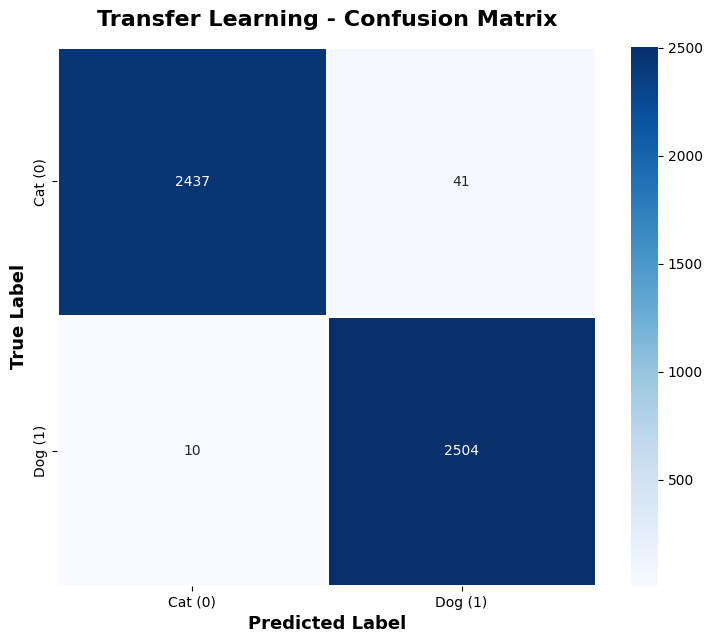

HOW TO READ THE CONFUSION MATRIX:
  Top-left: Cats correctly identified as cats (Good)
  Bottom-right: Dogs correctly identified as dogs (Good)
  Top-right: Cats wrongly predicted as dogs (Bad)
  Bottom-left: Dogs wrongly predicted as cats (Bad)

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Cat (0)     0.9959    0.9835    0.9896      2478
     Dog (1)     0.9839    0.9960    0.9899      2514

    accuracy                         0.9898      4992
   macro avg     0.9899    0.9897    0.9898      4992
weighted avg     0.9899    0.9898    0.9898      4992



In [15]:
#confusion Matrix

print("="*50)
print("Confusion Matrix")
print("="*50)

val_generator.reset()
val_steps = val_generator.samples // val_generator.batch_size

all_predictions = []
all_labels = []

print("Making predictions on all validation images....")

for step in range(val_steps):
    val_img, val_lbls = next(val_generator)
    pred = model.predict(val_img, verbose = 0)
    all_predictions.extend((pred>0.5).astype(int).flatten())
    all_labels.extend(val_lbls.astype(int))

    if(step+1)%5 == 0:
        print(f"Processed {(step+1)*batch_size} images....")

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print(f"\nAnalyzed {len(all_labels)} validation images!")

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat (0)', 'Dog (1)'],
            yticklabels=['Cat (0)', 'Dog (1)'],
            cbar=True, square=True, linewidths=2)
plt.title('Transfer Learning - Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.show()

print("HOW TO READ THE CONFUSION MATRIX:")
print("=" * 50)
print("  Top-left: Cats correctly identified as cats (Good)")
print("  Bottom-right: Dogs correctly identified as dogs (Good)")
print("  Top-right: Cats wrongly predicted as dogs (Bad)")
print("  Bottom-left: Dogs wrongly predicted as cats (Bad)")
print("=" * 50)


print("\n" + "=" * 50)
print("DETAILED CLASSIFICATION REPORT:")
print("=" * 50)
print(classification_report(all_labels, all_predictions,
                          target_names=['Cat (0)', 'Dog (1)'],
                          digits=4))


In [16]:
#Final summary

print("="*50)
print("Completed Final summary")
print("="*50)

print("Day 4 (CNN from scratch):")
print("Built all layers from random weights")
print("Trained on 2K images")
print("Took ~2 hour")
print("Got ~82% accuracy")
print("\nDay 5 (Transfer Learning):")
print("Used pre-trained ResNet50")
print("Fine-tuned on same 2K images")
print("Took ~15 min")
print(f"Got {final_val_acc:.1f}% accuracy!")
print("\nTransfer learning = 99% of real-world AI!")


print("\nKEY INSIGHTS:")
print("Don't train from scratch if you don't have to!")
print("Pre-trained models save TIME and get BETTER results")
print("Industry uses: ResNet, VGG, EfficientNet, etc.")
print("You can fine-tune for ANY image task!")
print("_"*50)

Completed Final summary
Day 4 (CNN from scratch):
Built all layers from random weights
Trained on 2K images
Took ~2 hour
Got ~82% accuracy

Day 5 (Transfer Learning):
Used pre-trained ResNet50
Fine-tuned on same 2K images
Took ~15 min
Got 99.0% accuracy!

Transfer learning = 99% of real-world AI!

KEY INSIGHTS:
Don't train from scratch if you don't have to!
Pre-trained models save TIME and get BETTER results
Industry uses: ResNet, VGG, EfficientNet, etc.
You can fine-tune for ANY image task!
__________________________________________________
